# Stock purchase recommendations with Machine Learning - Performance Backtesting

In [1]:
import pandas as pd
import numpy as np
import talib as ta
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook # progress bar
import fastparquet
import pickle

## next: add backtesting

In [2]:
# load the training and test datae from feature engineering step:
X_train = fastparquet.ParquetFile('../data/processed/X_train.parq').to_pandas()
X_test = fastparquet.ParquetFile('../data/processed/X_test.parq').to_pandas()
y_train = pickle.load(open('../data/processed/y_train.pkl', 'rb'))
y_test = pickle.load(open('../data/processed/y_test.pkl', 'rb'))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7024, 693), (1756, 693), (7024,), (1756,))

In [6]:
# load the model predictions:
y_pred_firstRF = pickle.load(open('../data/model_predictions/y_pred_firstRF.pkl', 'rb'))
y_pred_GridSearch = pickle.load(open('../data/model_predictions/y_pred_GridSearch.pkl', 'rb'))

In [7]:
# load the ticker list:
symbols = fastparquet.ParquetFile('../data/processed/symbols.parq').to_pandas().index.tolist()
print(symbols)

['AAPL.US', 'INTC.US', 'MSFT.US', 'AMZN.US', 'CSCO.US', 'NFLX.US', 'ABBV.US', 'GE.US']


In [8]:
# build dataframe with dates, stock tickers, real setup for profitable trade, and prediction
df_backtest = pd.concat([X_test.loc[:, symbols], y_test], axis=1)

# add result from ML predictions
df_backtest['y_pred_firstRF'] = y_pred_firstRF

# add result from ML predictions
df_backtest['y_pred_GridSearch'] = y_pred_GridSearch

# the BuyAndHold strategy can be replicated by setting the buy to True and then having a holding period as long as the backtest time period
df_backtest['BuyAndHold'] = True
df_backtest.head()

,AAPL.US,INTC.US,MSFT.US,AMZN.US,CSCO.US,NFLX.US,ABBV.US,GE.US,setup_for_profitable_trade,y_pred_firstRF,y_pred_GridSearch,BuyAndHold
Index,,,,,,,,,,,,
2017-05-11,0,0,1,0,0,0,0,0,False,False,False,True
2017-05-11,0,1,0,0,0,0,0,0,False,False,False,True
2017-05-11,0,0,0,0,0,1,0,0,False,False,False,True
2017-05-11,0,0,0,0,1,0,0,0,False,False,False,True
2017-05-11,1,0,0,0,0,0,0,0,False,False,False,True


In [9]:
# Build a table (dataframe) that contains descriptions (will be used as chart legends) for each column in the backtest datatrame
backtest_col_meta = pd.DataFrame(columns=['description', 'value_col_name'])
                     
backtest_col_meta.loc['setup_for_profitable_trade', 'description'] = 'Unachievable strategy best case (back-tested with hindsight)'
backtest_col_meta.loc['setup_for_profitable_trade', 'buy_on_day_plus_x'] = 1
backtest_col_meta.loc['setup_for_profitable_trade', 'sell_on_day_plus_x'] = 10

backtest_col_meta.loc['BuyAndHold', 'description'] = 'Buy and Hold Strategy'
backtest_col_meta.loc['BuyAndHold', 'buy_on_day_plus_x'] = 1
backtest_col_meta.loc['BuyAndHold', 'sell_on_day_plus_x'] = df_backtest.shape[0]+1 # setting the holding period to the whole backtest duration

backtest_col_meta.index.rename('col_name', inplace=True)
backtest_col_meta.loc['y_pred_firstRF', 'description'] = 'Model prediction from first RandomForest'
backtest_col_meta.loc['y_pred_firstRF', 'buy_on_day_plus_x'] = 1
backtest_col_meta.loc['y_pred_firstRF', 'sell_on_day_plus_x'] = 10

backtest_col_meta.index.rename('col_name', inplace=True)
backtest_col_meta.loc['y_pred_GridSearch', 'description'] = 'Model prediction after Gridsearch'
backtest_col_meta.loc['y_pred_GridSearch', 'buy_on_day_plus_x'] = 1
backtest_col_meta.loc['y_pred_GridSearch', 'sell_on_day_plus_x'] = 10

backtest_col_meta['value_col_name'] = backtest_col_meta.index.values + '_value' # these are created later when running the backtest calculation

backtest_col_meta

,description,value_col_name,buy_on_day_plus_x,sell_on_day_plus_x
col_name,,,,
setup_for_profitable_trade,Unachievable strategy best case (back-tested w...,setup_for_profitable_trade_value,1.0,10.0
BuyAndHold,Buy and Hold Strategy,BuyAndHold_value,1.0,1757.0
y_pred_firstRF,Model prediction from first RandomForest,y_pred_firstRF_value,1.0,10.0
y_pred_GridSearch,Model prediction after Gridsearch,y_pred_GridSearch_value,1.0,10.0


In [10]:
# load the df_downloaded_all_ticker dataframe from feature engineering step:
df_downloaded_all_tickers = fastparquet.ParquetFile('../data/processed/df_downloaded_all_tickers.parq').to_pandas()
df_downloaded_all_tickers.tail()

,AdjVolume,AdjOpen,AdjLow,AdjHigh,AdjClose,ticker
Index,,,,,,
2018-03-27,11890994.0,322.49,297.0000,322.90,300.69,NFLX.US
2018-03-27,10747585.0,95.50,91.1223,95.72,92.01,ABBV.US
2018-03-27,153476613.0,12.92,12.8200,13.72,13.44,GE.US
2018-03-27,37076576.0,53.01,50.7800,53.25,51.19,INTC.US
2018-03-27,38962839.0,173.68,166.9200,175.15,168.34,AAPL.US


### build support functions that can calculate the total value of a backtest over time and plot performance chart

In [11]:
def calculate_backtest(backtest_df, signal_col_name, buy_on_day_plus_x, sell_on_day_plus_x, verbose=False):
    '''
    Calculates profit of strategy on the stock data given, starting cash is 100
    Strategy is hardcoded into function: buy on the open and sell on the open as controlled by parameters
    Go all in or all out, no partial positions and ignore additional long signals until exited position
    Inputs
        backtest_df - dataframe with Adjusted OHLC data
        signal_col_name - name of column used to trigger the execution of the stategy
        results_col_prefix - prefix for columns in output for cols capital, stocks_owned, value
        buy_on_day_plus_x - number of days after signal date on which the stock is purchased at the AdjOpen price
        sell_on_day_plus_x - number of dasy after signal date on which the stock is sold at the AdjOpen price
    Output
        backtest_df_with_profits
    '''
    
    # setup column names for outputs - using prefix allows to run backtest on same backtest_df for multiple predictions and
    # keep results in separate output columns
    results_col_prefix = signal_col_name + '_'
    capital_col_name = results_col_prefix + 'captial' # cash on hand balance
    stocks_owned_col_name = results_col_prefix + 'stocks_owned' # number of shares owned (fractional are allowed)
    value_col_name = results_col_prefix + 'value' # total value = cash + #shares times share price
    
    # initial capital $100
    capital = 100
    backtest_df[capital_col_name] = capital
    # initially don't own any of the stock
    stocks_owned = 0
    backtest_df[stocks_owned_col_name] = stocks_owned
    # initially set to false:
    buy_stock_on_next_open = False
    sell_stock_on_next_open = False
    buy_in_x_days = -1
    sell_in_x_days = -1
    
    # loop through all dates in chronological order
    for date in backtest_df.index:
    
        #set capital and stocks_owned for day to current state
        backtest_df.loc[date, capital_col_name] = capital
        backtest_df.loc[date, stocks_owned_col_name] = stocks_owned
        
        if (buy_in_x_days == 0) & (backtest_df.loc[date, stocks_owned_col_name] == 0):
            # time to buy and currently not already owning the stock (otherwise skip signal and wait for sell)
            # buy today on the AdjOpen:
            # calculate number of shares

            if verbose:
                print('buying now')
                
            backtest_df.loc[date, stocks_owned_col_name] = backtest_df.loc[date, capital_col_name] / backtest_df.loc[date, 'AdjOpen']
            # set capital to zero
            backtest_df.loc[date, capital_col_name] = 0
        
        if (sell_in_x_days == 0) & (backtest_df.loc[date, capital_col_name] == 0):
            # time to sell and have stocks to sell:
            # sell today on the AdjOpen:
            # calculate cash from sale of stock
            if verbose:
                print('selling now')
                
            backtest_df.loc[date, capital_col_name] = backtest_df.loc[date, stocks_owned_col_name] * backtest_df.loc[date, 'AdjOpen']
            # set stocks owned to zero
            backtest_df.loc[date, stocks_owned_col_name] = 0


        #set capital and stocks_owned for day to current state
        capital = backtest_df.loc[date, capital_col_name]
        stocks_owned = backtest_df.loc[date, stocks_owned_col_name]
        
        if (backtest_df.loc[date, signal_col_name] == True) & (backtest_df.loc[date, stocks_owned_col_name] == 0):
            # we have a signal, set the counters for countdowns to buy and then sell
            buy_in_x_days = buy_on_day_plus_x
            sell_in_x_days = sell_on_day_plus_x
            
        buy_in_x_days += -1
        sell_in_x_days += -1    
        
        # calculate total value of cash and stock at close price
        backtest_df.loc[date, value_col_name] = capital + stocks_owned * backtest_df.loc[date, 'AdjClose']
        
        if verbose:
            print(date, backtest_df.loc[date, signal_col_name], 
                      buy_in_x_days, sell_in_x_days,
                      backtest_df.loc[date, capital_col_name], 
                      backtest_df.loc[date, stocks_owned_col_name],
                      backtest_df.loc[date, value_col_name],
                      backtest_df.loc[date, 'AdjOpen'])
        
    return backtest_df
        
def show_chart_of_backtest_result(backtest_df, cols_to_plot):
    '''
    Plots chart of AdjClose (normalized to 100) and 'value' column of the backtest result - shows over/under performance
    Input
        backtest_df - dataframe with backtest results
        cols_to_plot - list of column names to plot
    '''
    
    ax = backtest_df[backtest_col_meta.loc[cols_to_plot, 'value_col_name'].values].plot(figsize=(15,7))
    ax.legend(backtest_col_meta.loc[cols_to_plot, 'description']) # change legend descriptions 
    plt.title('Simulation of strategy value for ticker ' + backtest_df.ticker[0] + ' compared to Buy and Hold')
    plt.show()  

## Cycle through all tickers and visualize performance of predictions

calculating backtest for: AAPL.US
Performance of Unachievable strategy best case (back-tested with hindsight) :    49.56%
Performance of Buy and Hold Strategy :     9.26%
Performance of Model prediction from first RandomForest :     2.64%
Performance of Model prediction after Gridsearch :    18.13%


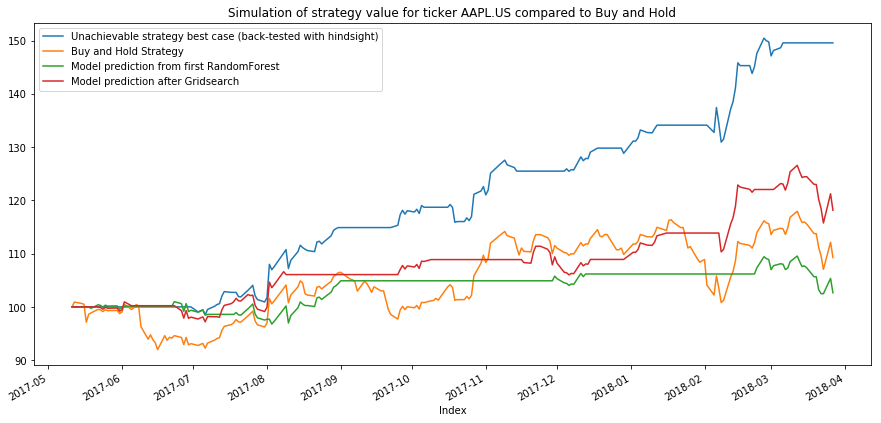


calculating backtest for: INTC.US
Performance of Unachievable strategy best case (back-tested with hindsight) :    96.52%
Performance of Buy and Hold Strategy :    46.07%
Performance of Model prediction from first RandomForest :     4.91%
Performance of Model prediction after Gridsearch :    10.14%


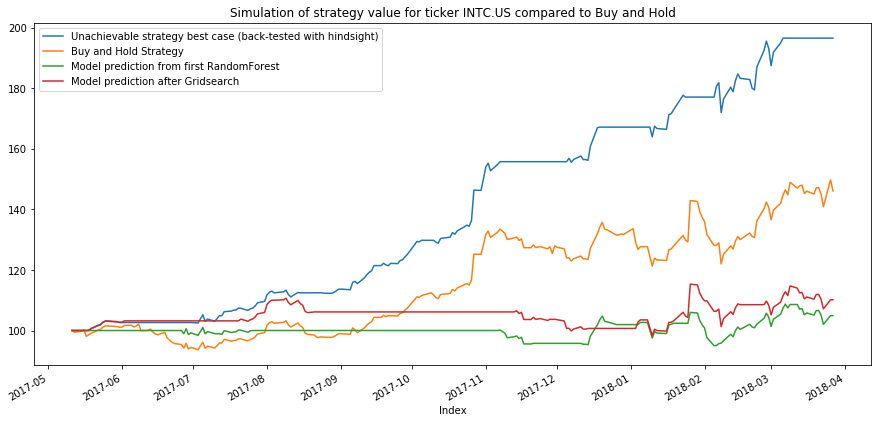


calculating backtest for: MSFT.US
Performance of Unachievable strategy best case (back-tested with hindsight) :    51.70%
Performance of Buy and Hold Strategy :    32.50%
Performance of Model prediction from first RandomForest :    17.55%
Performance of Model prediction after Gridsearch :    15.04%


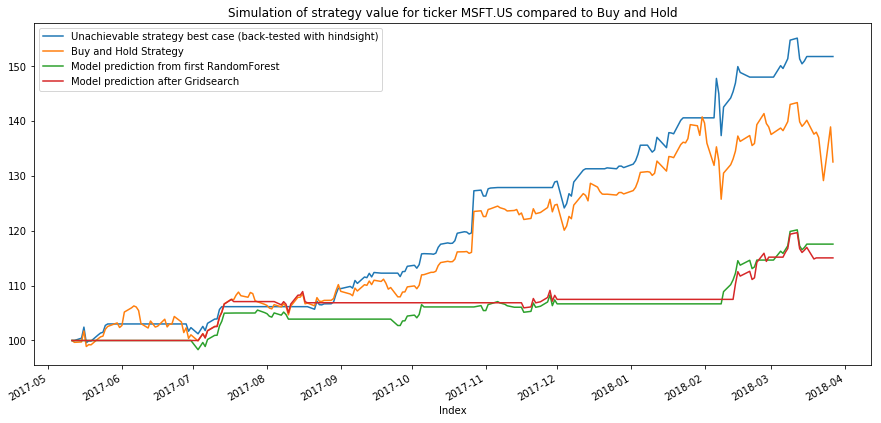


calculating backtest for: AMZN.US
Performance of Unachievable strategy best case (back-tested with hindsight) :    86.64%
Performance of Buy and Hold Strategy :    56.84%
Performance of Model prediction from first RandomForest :    27.90%
Performance of Model prediction after Gridsearch :     6.07%


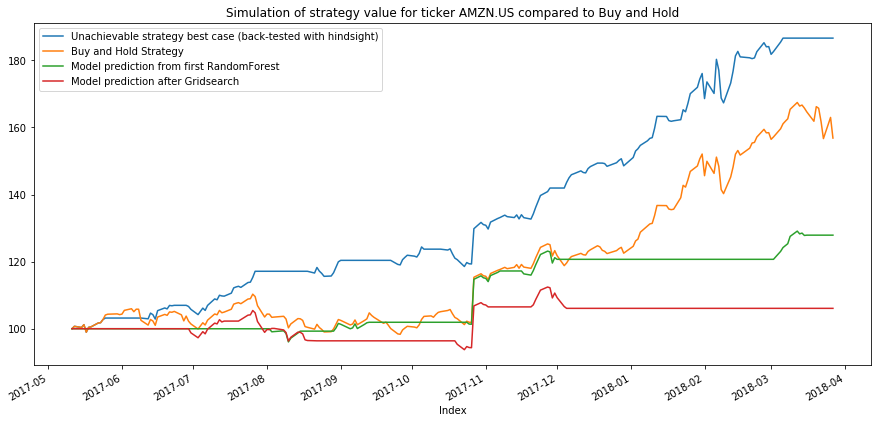


calculating backtest for: CSCO.US
Performance of Unachievable strategy best case (back-tested with hindsight) :    70.42%
Performance of Buy and Hold Strategy :    29.32%
Performance of Model prediction from first RandomForest :    10.23%
Performance of Model prediction after Gridsearch :     3.53%


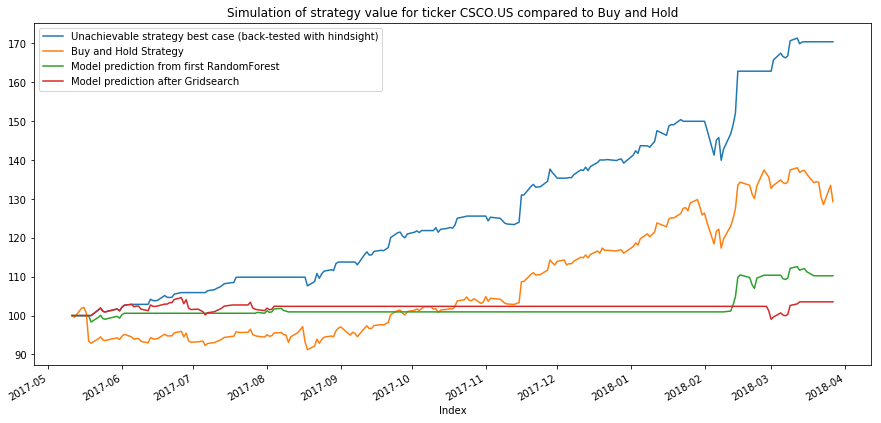


calculating backtest for: NFLX.US
Performance of Unachievable strategy best case (back-tested with hindsight) :   148.36%
Performance of Buy and Hold Strategy :    88.98%
Performance of Model prediction from first RandomForest :    58.46%
Performance of Model prediction after Gridsearch :    38.28%


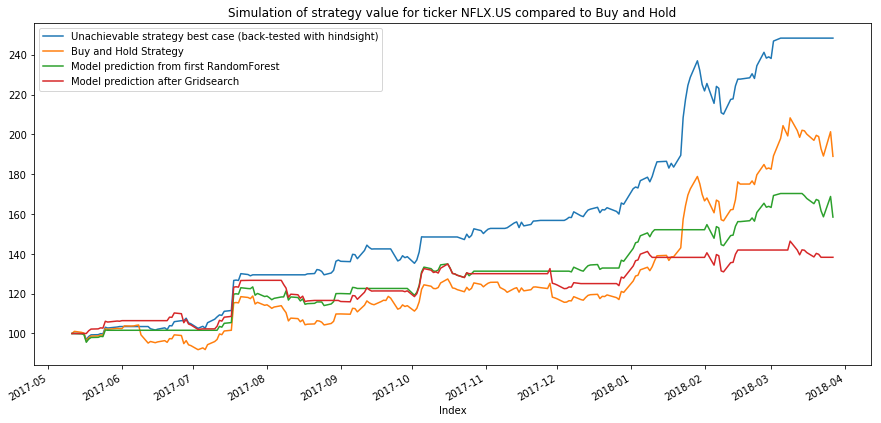


calculating backtest for: ABBV.US
Performance of Unachievable strategy best case (back-tested with hindsight) :   108.70%
Performance of Buy and Hold Strategy :    43.22%
Performance of Model prediction from first RandomForest :    12.00%
Performance of Model prediction after Gridsearch :    11.81%


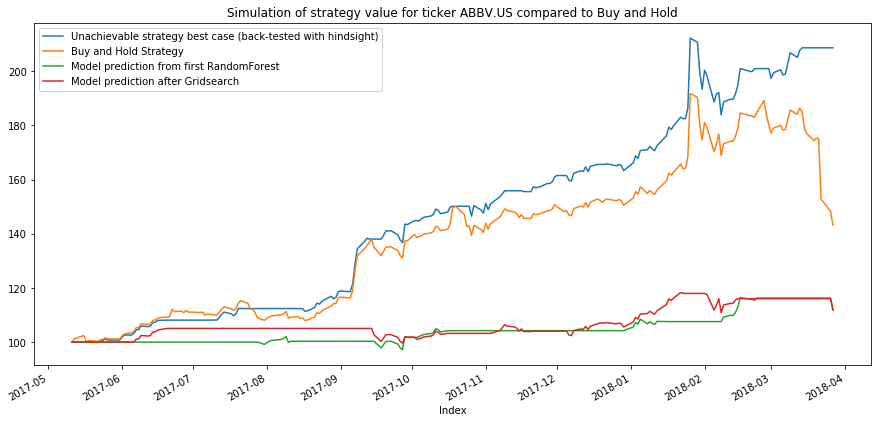


calculating backtest for: GE.US
Performance of Unachievable strategy best case (back-tested with hindsight) :    22.77%
Performance of Buy and Hold Strategy :   -51.74%
Performance of Model prediction from first RandomForest :   -37.09%
Performance of Model prediction after Gridsearch :   -47.46%


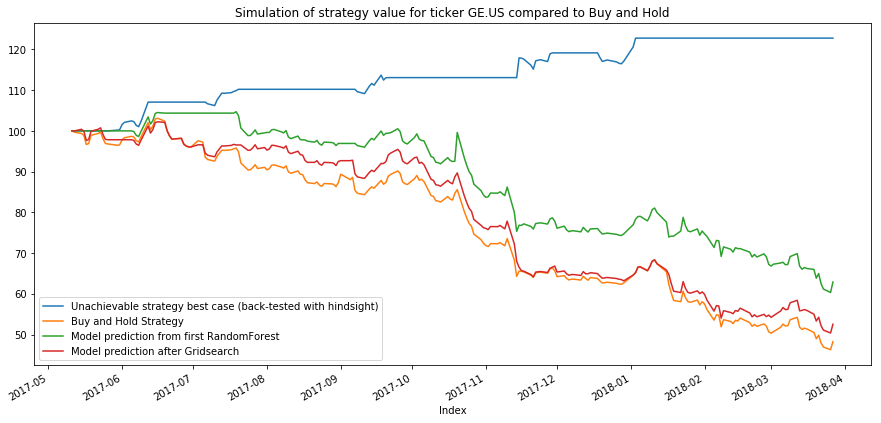

In [12]:
# cycle through all tickers and calculate performance of prediction for each
for ticker in tqdm_notebook(symbols):
    print('calculating backtest for: ' + ticker)
   
    # make list of the columns we will run through in the backtest:
    backtest_cols_list = backtest_col_meta.index.values.tolist() # all the simulations and backtests
    col_list = backtest_cols_list.copy() # need a copy so we can use backtest_cols_list later to cycle through for backtesting
    col_list.append(ticker) # the stock ticker for this iteration

    # pull out all rows for current ticker - and use the column list built above
    df_backtest_this_ticker = df_backtest.loc[df_backtest[ticker]==1, col_list] 
    
    ##### 1) get the downloaded stock data for this ticker and for the dates that will be part of the backtest
       
    # pull out the data for current ticker
    df_downloaded_data_this_ticker = df_downloaded_all_tickers.loc[ df_downloaded_all_tickers['ticker']==ticker, :]
    # now ensure we only use the same dates as in the backtest for this ticker
    df_downloaded_data_this_ticker_backtest_dates = df_downloaded_data_this_ticker.loc[df_backtest_this_ticker.index, :]
    
    # ensure same dates in index
    assert (df_backtest_this_ticker.index == df_downloaded_data_this_ticker_backtest_dates.index).all
    # ensure we got the right rows from the downloaded data for this stock
    assert (ticker == df_downloaded_data_this_ticker_backtest_dates['ticker']).all
    
    # now that we know we have the right data, keep only most important columns
    df_downloaded_data_this_ticker_backtest_dates = df_downloaded_data_this_ticker_backtest_dates[['AdjOpen', 'AdjClose', 
                                                                                                  'AdjHigh', 'AdjLow', 'ticker']]
    
    # build dataframe that has downloaded data and prediction and true strategy result for backtest time period
    df_backtest_this_ticker_with_downloaded_data = df_backtest_this_ticker.join(df_downloaded_data_this_ticker_backtest_dates)
    
    ###### we now have the dataframe with the original stock price data and a prediction column

    backtest_df = df_backtest_this_ticker_with_downloaded_data

    # cycle through the backtest_cols_list and calculate the backtest results for each
    for col_to_backtest in backtest_cols_list:
        backtest_df = calculate_backtest(backtest_df, col_to_backtest, 
                                     buy_on_day_plus_x = backtest_col_meta.loc[col_to_backtest, 'buy_on_day_plus_x'],
                                     sell_on_day_plus_x = backtest_col_meta.loc[col_to_backtest, 'sell_on_day_plus_x'],
                                     verbose=False)
        
        print('Performance of {0:} : {1:8.2f}%'.format(
            backtest_col_meta.loc[col_to_backtest, 'description'],
            backtest_df[backtest_col_meta.loc[col_to_backtest, 'value_col_name']][-1]-100)
             )
        
    show_chart_of_backtest_result(backtest_df, cols_to_plot = backtest_cols_list)

    print('')
       
    
    

In [13]:
backtest_df.head()

,setup_for_profitable_trade,BuyAndHold,y_pred_firstRF,y_pred_GridSearch,GE.US,AdjOpen,AdjClose,AdjHigh,AdjLow,ticker,...,setup_for_profitable_trade_value,BuyAndHold_captial,BuyAndHold_stocks_owned,BuyAndHold_value,y_pred_firstRF_captial,y_pred_firstRF_stocks_owned,y_pred_firstRF_value,y_pred_GridSearch_captial,y_pred_GridSearch_stocks_owned,y_pred_GridSearch_value
Index,,,,,,,,,,,,,,,,,,,,,
2017-05-11,False,True,False,False,1,28.161672,28.348238,28.367877,27.984925,GE.US,...,100.0,100,0.000000,100.000000,100.0,0.0,100.0,100.0,0.000000,100.000000
2017-05-12,False,True,False,True,1,27.847455,27.759082,27.935829,27.346672,GE.US,...,100.0,0,3.590992,99.682652,100.0,0.0,100.0,100.0,0.000000,100.000000
2017-05-15,False,True,False,False,1,27.562696,27.670708,27.729624,27.464504,GE.US,...,100.0,0,3.590992,99.365303,100.0,0.0,100.0,0.0,3.628092,100.391877
2017-05-16,False,True,False,False,1,27.739443,27.533238,27.768901,27.493961,GE.US,...,100.0,0,3.590992,98.871650,100.0,0.0,100.0,0.0,3.628092,99.893124
2017-05-17,False,True,False,False,1,27.317215,26.914624,27.366311,26.914624,GE.US,...,100.0,0,3.590992,96.650212,100.0,0.0,100.0,0.0,3.628092,97.648735


## use TPOT